# Hierarchical Multivariate Bayesian Linear Models
using python, pymc3, patsy, theano

Falk Mielke, Universiteit Antwerpen, 2018/07/14

In result of [this](https://discourse.pymc.io/t/correlated-slopes-in-multivariate-model/1485) discussion. All of this is more or less directly adapted from code by [Junpeng Lao](https://discourse.pymc.io/u/junpenglao) or [Jack Caster](https://discourse.pymc.io/u/Jack_Caster).
Thank you both for the amazing support!

#### Resources (incomplete list):

- https://discourse.pymc.io/t/advance-bayesian-modelling-with-pymc3/1439  # session 6: modelling multivariate observation
- notebooks by Jack Caster: https://github.com/JackCaster/GLM_with_PyMC3
- https://discourse.pymc.io/t/cholesky-decomposition-and-correlation-among-random-effects/1210
- http://docs.pymc.io/notebooks/LKJ.html
- http://docs.pymc.io/api/distributions/multivariate.html
- https://stackoverflow.com/questions/39677240/multivariate-linear-regression-in-pymc3
- https://stackoverflow.com/questions/39364919/pymc3-how-to-model-correlated-intercept-and-slope-in-multilevel-linear-regressi
- http://austinrochford.com/posts/2015-09-16-mvn-pymc3-lkj.html
- Michael Betancourt: "A Conceptual Introduction to Hamiltonian Monte Carlo"; https://arxiv.org/abs/1701.02434
- Barnard et al.: "Modeling covariance matrices in terms of standard deviations and correlations, with application to shrinkage", http://www3.stat.sinica.edu.tw/statistica/oldpdf/A10n416.pdf https://www.jstor.org/stable/24306780
- Lewandowski, Kurowicka, Joe: "Generating random correlation matrices based on vines and extended onion method", https://doi.org/10.1016/j.jmva.2009.04.008

Always good:
- Richard McElreath: "Statistical Rethinking", http://xcelab.net/rm/statistical-rethinking/
- Andrew Gelman *et al.*: "Bayesian Data Analysis", http://www.stat.columbia.edu/~gelman/book/


In [1]:
# libraries
import numpy as NP
import pandas as PD
import pymc3 as PM
import theano.tensor as TT
import patsy as PA

import matplotlib.pyplot as PLT
import seaborn as SB
%matplotlib inline

seed = 42
NP.random.seed(seed)

%load_ext watermark


/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%watermark -v -m -p numpy,pandas,theano,pymc3,patsy,matplotlib,seaborn

CPython 3.6.6
IPython 6.4.0

numpy 1.14.5
pandas 0.23.1
theano 1.0.1+unknown
pymc3 3.4.1
patsy 0.5.0
matplotlib 2.2.2
seaborn 0.8.1

compiler   : GCC 8.1.1 20180531
system     : Linux
release    : 4.17.2-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 4
interpreter: 64bit


## Data Generation

### Simulated Data

Data herein will have the following structure:
- **observables**: measurements of interest, i.e. dependent variables; example: distance covered, rewards found during a fixed time search task
- **covariates**: parameters that are also measured and putatively influence the observables; example: temperature, day time
- **subjects**: repeated measurements of the same condition; example: participants (subjects)
- **groups**: related measurements; example: same subject pre/post treatment
- **modifiers**: subject characteristics, example: age, sex
- **predictors**: modifiers + covariates, i.e. independent variables
- **uncertainty**: measurement error
- **slope**: an effect that one variable has on another

This complex structure mimics my actual data set. Thus, when the model works (successful parameter recovery), I will be pretty confident that technically everything is in place.

Even more, I can play with the sample sizes and anticipate how many experiments will be necessary to be able to distinguish effects. This is a powerful feature of *ex ante* simulation which I have long underestimated.

On the other hand, one has to keep in mind that simulations are tautologous: one gets out what one puts in, which is the conceptual structure of the model. Even more, the model structure is forced onto the data. Avoiding meaningless results requires a lot of careful consideration and model selection. Thus, when data is at hand, do not stick to a model, try everything.

Here we assemble random data with parameter values that are to be recovered later.

In [3]:
def GenerateDataSimulation(count = {}, actual = {}, label = {}):
    # construct artificial, but realistic data from random generators

#_______________________________________________________________________________
    ### observables
    # we obtained two observables of interest.
    count['observables'] = 2
    label['observables'] = ['obs%i' % (observable_nr+1) for observable_nr in range(count['observables'])]
    actual['observables_intercept'] = [0.8, 1.3]
    actual['observables_covariance_matrix'] = NP.array([ \
                                                  [  1.0, -0.1 ] \
                                                , [ -0.1,  1.0 ] \
                                                ])
    
    # measurement inaccuracy
    actual['uncertainty'] = 0.05

    ### covariates
    # we assessed values of three covariates
    # which are correlated
    label['covariates'] = ['cov1', 'cov2', 'cov3']
    count['covariates'] = len(label['covariates'])
    actual['covariates_mean'] = NP.array([ 1, -1.8, 0.5 ])
    
    # covariation within the covariates
    actual['covariates_covariance_matrix'] = NP.array([ \
                                                  [  1.1, -0.3,  0.1 ] \
                                                , [ -0.3,  0.8,  0.6 ] \
                                                , [  0.1,  0.6,  1.0 ] \
                                                ])

    # effect of the covariates on the observables
    actual['covariates_slopes'] = NP.array([ \
                                                  [  0.40, -0.60,  0.05 ] \
                                                , [  0.00, -0.20,  0.35 ] \
                                                ])


    ### groups
    # data was measured from groups (subjects), giving it hierarchical structure.
    count['groups'] = 2**4
    count['observations_per_group'] = 100
    
    # slightly different intercept for each group
    actual['intercepts'] = NP.stack([ \
                                NP.random.normal(actual['observables_intercept'][nr], 0.4, count['groups'])
                                for nr in range(count['observables']) \
                                ], axis = 1)

    ### modifiers
    # independent attributes of the groups (only acquired on subject level)
    # also conceptually distinct/independent from the covariates
    label['modifiers'] = ['mod1', 'mod2']
    count['modifiers'] = len(label['modifiers'])
    
    # the first modifier, such as subject age
    actual['mod1'] = NP.random.normal(4., 1.5, count['groups'])
    actual['mod1_slopes'] = NP.random.normal(0.2, 0.1, (count['observables'], count['groups']))
    actual['mod1_covariate_effect'] = NP.array([  0.00, -0.30,  0.08 ])
    actual['mod1_covcorr_effect'] = NP.zeros((3,))

    # the second modifier: comes in two blocks that can be categorized
    actual['mod2'] = {False: NP.random.normal(1.3, 0.2, count['groups']) \
                         , True: NP.random.normal(0.9, 0.2, count['groups'])}
    actual['mod2_slopes'] = NP.random.normal(-0.1, 0.05, (count['observables'], count['groups']))
    actual['mod2_covariate_effect'] = NP.array([  -0.03, 0.01,  0.25 ])
    
    ### organizational
    label['predictors'] = label['modifiers'] + label['covariates']
    count['predictors'] = count['modifiers'] + count['covariates']

    
    
#_______________________________________________________________________________
    ### measurements
    data = []
    for grp_idx in range(count['groups']):
        for mod2_category in [False, True]:
            # covariance structure of the covariates
            simulation = NP.random.multivariate_normal(  actual['covariates_mean'] \
                                                       , actual['covariates_covariance_matrix'] \
                                                       , size = count['observations_per_group'] \
                                                      )
            simulation = PD.DataFrame( simulation \
                            , columns = label['covariates'] \
                            , index = (grp_idx*2+int(mod2_category))*count['observations_per_group'] + NP.arange(count['observations_per_group']) \
                            )


            # group-level parameters
            simulation['subject'] = 's%02.0f' % (1+grp_idx*2+int(mod2_category))
            simulation['group'] = 'g%02.0f' % (grp_idx+1)
            simulation['mod2_category'] = mod2_category
            simulation['mod1'] = actual['mod1'][grp_idx]
            simulation['mod2'] = actual['mod2'][mod2_category][grp_idx]

            # covariates are influenced by modifiers
            for cov_nr, cov in enumerate(label['covariates']):
                simulation[cov] += actual['mod1'][grp_idx] * actual['mod1_covariate_effect'][cov_nr] \
                                 + actual['mod2'][mod2_category][grp_idx] \
                                   * actual['mod2_covariate_effect'][cov_nr]

            ### observables
            # intercept, multivariate structure
            obs_simulation = NP.random.multivariate_normal(   actual['intercepts'][grp_idx, :] \
                                                            , actual['observables_covariance_matrix'] \
                                                            , size = count['observations_per_group'] \
                                                            )
            
            for obs_nr, observable in enumerate(label['observables']):
                # add group effects
                simulation[observable] = obs_simulation[:, obs_nr] \
                                       + NP.random.normal( 0. \
                                                        , actual['uncertainty'] \
                                                        , count['observations_per_group'] \
                                                        ) \
                                       + actual['mod1'][grp_idx] * actual['mod1_slopes'][obs_nr, grp_idx] \
                                       + actual['mod2'][mod2_category][grp_idx] \
                                         * actual['mod2_slopes'][obs_nr, grp_idx]
                
                # add covariates effects
                for cov_nr, cov in enumerate(label['covariates']):
                    simulation[observable] += actual['covariates_slopes'][obs_nr, cov_nr] * simulation.loc[:, cov].values
                    

            # store data (sorted)
            data.append(simulation.loc[: \
                                  , ['subject', 'group', 'mod2_category'] \
                                    + label['predictors'] \
                                    + label['observables'] \
                                ])

    ### combine data
    data = PD.concat(data, axis = 0)
    count['observations'] = data.shape[0]

    ### categorical grouping, pandas style
    data['group'] = PD.Categorical(data['group'], ordered = False)
    groups = list(data['group'].cat.categories)
    data['group_index'] = data['group'].cat.codes.values
    
    ### done
    return data, count, actual, label


data, count, actual, label = GenerateDataSimulation(count = {}, actual = {}, label = {})

### check simulation

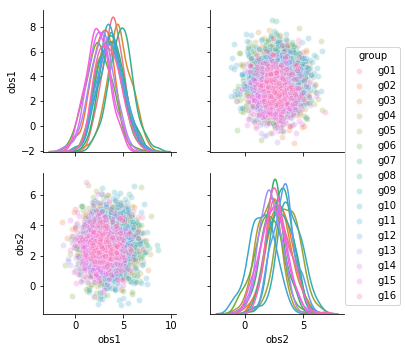

In [4]:
### relation of observables
SB.pairplot(data \
        , hue = 'group' \
        , vars = label['observables'] \
        , diag_kind = 'kde' \
        , plot_kws = dict(alpha = .25) \
         )
PLT.show()


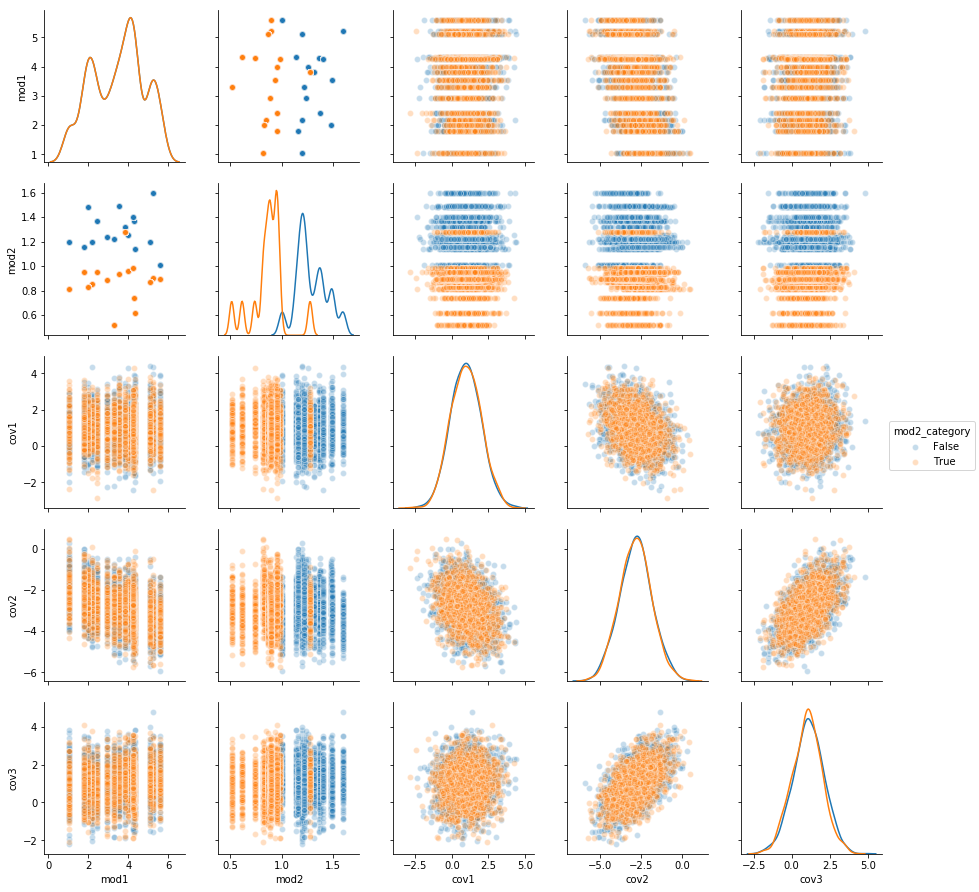

In [5]:
### relation of covariates
SB.pairplot(data \
        , hue = 'mod2_category' \
        , vars = label['predictors'] \
        , diag_kind = 'kde' \
        , plot_kws = dict(alpha = .25) \
         )
PLT.show()

In [6]:
### reorganize data for seaborn.lmplot
plot_data = []
for cov in label['covariates']:
    for obs in label['observables']:
        sub_data = data.loc[:, ['group', 'mod2_category', cov, obs]].copy()
        sub_data['covariate'] = cov
        sub_data['observable'] = obs
        sub_data.rename(columns = {cov: 'covariate_value', obs: 'observable_value'}, inplace = True)

        plot_data.append(sub_data.loc[:,['group','mod1','mod2','mod2_category','covariate','observable','covariate_value','observable_value']])

plot_data = PD.concat(plot_data)

/usr/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


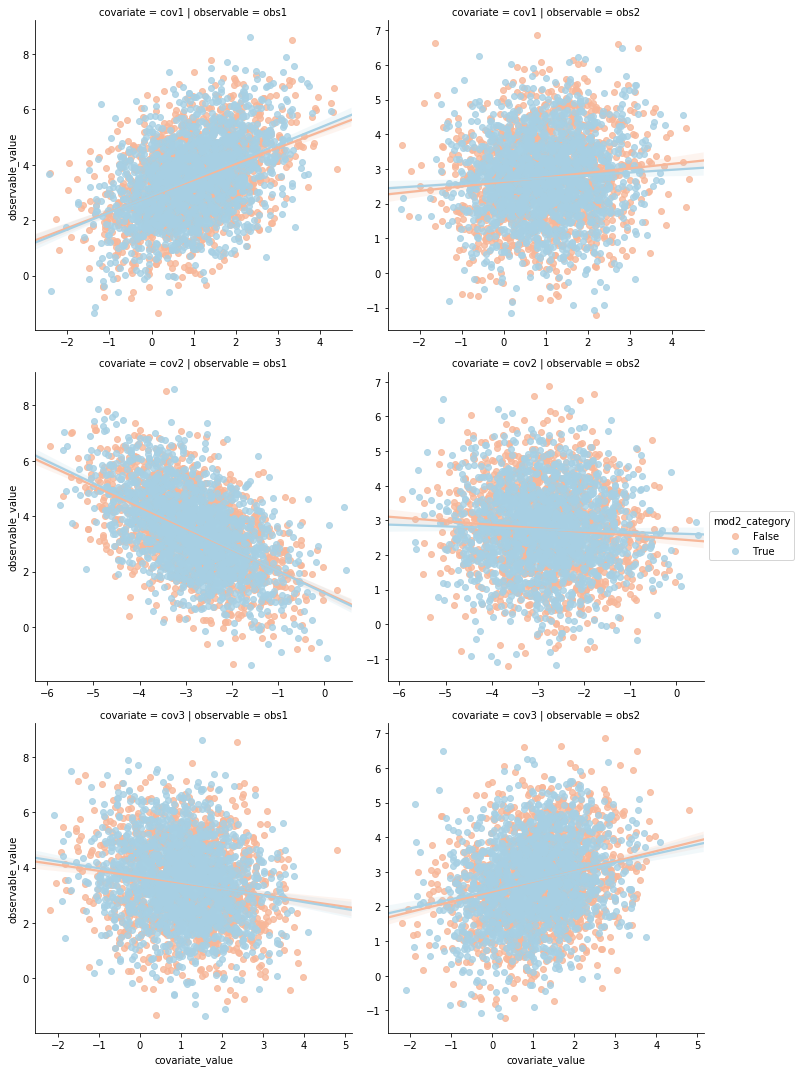

In [7]:
### relation of covariates/observables
SB.lmplot(x = 'covariate_value' \
        , y = 'observable_value' \
        , hue = 'mod2_category' \
        , row = 'covariate' \
        , col = 'observable' \
        , data = plot_data \
        , palette = 'RdBu' \
        , sharex = False \
        , sharey = False \
        )
PLT.show()

Seems like the effects I intended to cover are actually in. That is a good basis for what is to come next.

## Model Construction

### Matrix Notation

For linear mixed models in `pymc3`, the Matrix formulation (using `patsy` design matrices) has several advantages:

- it is modular and allows for a combination (sequential addition) of different model components
- matrix operations with `theano` are very efficient, leading to quicker sampling

Some complications may arise, though:

- matrix operations require some getting used to (at least for a humble Biologist like me)
- in particular, the shape of matrix objects needs to be monitored (see tipps in the code)


Like with the idea of using `patsy` formula syntax for design matrix construction, I tried to avoid single letter abbreviations to retain clarity - some readers might not immediately catch the beauty of something like 
$$\theta_k = \alpha_k + \sum\limits_i X_{ki}\beta_{ki} + \sum\limits_j Z_{kj}\gamma_{kj} + \epsilon$$
(though I must admit I am beginning to like it). In my opinion, explicit variable names are useful and save me from a lot of documentation. On the same line, you might have noticed that I use capital letters for python libraries - yes, that's kind of rebellious for python, but I've just gotten used to it.

### Design Matrices
And now fore some design matrices:

- "`_dmatrix`" will be "fixed effects" random matrix component, i.e. parameters that are estimated on population level
- "`_grpmatrix`" will be "random effects", i.e. parameter estimates on subject level

In [8]:

intercept_dmatrix = NP.asarray(PA.dmatrix( "1" \
                                        , data = data \
                                        , return_type = 'dataframe' \
                                        ))
modifier_dmatrix = NP.asarray(PA.dmatrix(  "0 + %s" % (" + ".join(label['modifiers'])) \
                                        , data = data \
                                        , return_type = 'dataframe' \
                                        ))
covariate_dmatrix = NP.asarray(PA.dmatrix( "0 + %s" % (" + ".join(label['covariates'])) \
                                        , data = data \
                                        , return_type = 'dataframe' \
                                        ))
# first way to keep track of matrix dimensions:
print('intercept_dmatrix has shape ({}, {})'.format(*intercept_dmatrix.shape)) 
print('modifier_dmatrix has shape ({}, {})'.format(*modifier_dmatrix.shape))
print('covariate_dmatrix has shape ({}, {})'.format(*covariate_dmatrix.shape))


intercept_grpmatrix = NP.asarray(PA.dmatrix( '0 + group' \
                                        , data = data \
                                        , return_type = 'dataframe' \
                                        ))

covariate_grpmatrix = NP.asarray(PA.dmatrix( "0 + %s" % (" + ".join( \
                                            ["%s:group" % (cov) for cov in label['covariates']]\
                                            )) \
                                        , data = data \
                                        , return_type = 'dataframe' \
                                        ))


intercept_dmatrix has shape (3200, 1)
modifier_dmatrix has shape (3200, 2)
covariate_dmatrix has shape (3200, 3)


### Model Definition

Below is the definition of a pymc model.

Its additive components are: 
- intercept (population and subject level)
- modifier slopes
- covariates (with multivariate covariance structure, on population and subject level)
- observables (multivariate covariance structure)

Note that I chose very narrow priors, since I designed the model to have approximately O(1) standard deviation. 

In [9]:
# the model
with PM.Model() as model:

### intercept
    # (a) population level
    population_intercept = PM.Normal(  'population_intercept' \
                                     , mu = 0. \
                                     , sd = 1. \
                                     , shape = (intercept_dmatrix.shape[1], count['observables']) \
                                    )
    
    # (b) subject level, 'offset' parametrization (zero-centered difference from population)
    group_intercept_scaler = PM.HalfNormal(  'group_intercept_scaler' \
                                           , sd=1. \
                                           , shape=(count['observables']) \
                                          ) 
    group_intercept_raw = PM.Normal(  'group_intercept_raw' \
                                    , mu=0. \
                                    , sd=1. \
                                    , shape=(intercept_grpmatrix.shape[1], count['observables']) \
                                   )
    group_intercept = PM.Deterministic(  'group_intercept' \
                                       , group_intercept_raw * group_intercept_scaler \
                                      )
    
    ## second way to keep track of matrix dimensions:
    # estimate_intercept_grp = PM.math.dot(intercept_grpmatrix, gamma_intercept_grp)
    # TT.printing.Print('estimate_intercept_grp')(estimate_intercept_grp.shape)
    
    # combine
    intercept_component = TT.dot(intercept_dmatrix, population_intercept) \
                        + PM.math.dot(intercept_grpmatrix, group_intercept) 

### modifiers
    population_modifiers = PM.Normal(  'population_modifiers' \
                               , mu = 0. \
                               , sd = 1. \
                               , shape = (modifier_dmatrix.shape[1], count['observables']) \
                              )
    
    # combine
    modifier_component = TT.dot(modifier_dmatrix, population_modifiers)
    
### covariates
    # ... are correlated, which needs to be incorporated in the model
    # prior for covariates covariance
    covariates_packed_cholesky = PM.LKJCholeskyCov( 'covariates_packed_cholesky' \
                                            , n = count['covariates'] \
                                            , eta = 1. \
                                            , sd_dist = PM.HalfCauchy.dist(2.) \
                                            )
    
    # compute the covariates covariance and correlation matrix 
    covariates_cholesky_matrix = PM.expand_packed_triangular(count['covariates'], covariates_packed_cholesky, lower = True)
    # (additional covariance diagnostics are possible, see below)
    covariates_covariance_matrix = PM.Deterministic('covariates_covariance_matrix' \
                                , TT.dot(covariates_cholesky_matrix, covariates_cholesky_matrix.T))

    
    # population effect, centered parametrization
    population_covariates = PM.MvNormal(  'population_covariates' \
                                        , mu = NP.zeros(count['covariates']) \
                                        , chol = covariates_cholesky_matrix \
                                        , shape = ( count['observables'], count['covariates'] ) \
                                        ) # (some error was thrown when inverting shape, so transposed below) 
    
    # group level effect
    group_covariates_scaler = PM.HalfNormal(  'group_covariates_scaler' \
                                            , sd = 1. \
                                            , shape = (count['observables']) \
                                           ) 
    group_covariates_raw = PM.Normal(  'group_covariates_raw' \
                                       , mu = 0. \
                                       , sd = 1. \
                                       , shape = (covariate_grpmatrix.shape[1], count['observables']) \
                                      )
    group_covariates = PM.Deterministic(  'group_covariates' \
                                              , group_covariates_raw * group_covariates_scaler \
                                             )

    # combine
    covariates_component = PM.math.dot(covariate_dmatrix, population_covariates.T) \
                         + PM.math.dot(covariate_grpmatrix, group_covariates)
    
    
    
### add up components
    estimator = intercept_component \
              + modifier_component \
              + covariates_component

    
### observables
    # prior for observables covariance
    packed_cholesky = PM.LKJCholeskyCov(  'packed_cholesky' \
                                        , n = count['observables'] \
                                        , eta = 1. \
                                        , sd_dist = PM.HalfCauchy.dist(2.) \
                                        )
    
    # compute the observables covariance and correlation matrix 
    cholesky_matrix = PM.expand_packed_triangular(count['observables'], packed_cholesky, lower = True)
    
    # additional covariance diagnostics
    # could alternatively be recovered from the Cholesky matrix posterior
    # thus, remove for complex models
    covariance_matrix = PM.Deterministic('covariance_matrix' \
                                         , TT.dot(cholesky_matrix, cholesky_matrix.T) \
                                        )
    standard_deviations = PM.Deterministic('standard_deviations' \
                                         , TT.sqrt(TT.diag(covariance_matrix)) \
                                        )
    correlation_matrix = PM.Deterministic('correlation_matrix' \
                                        , TT.diag(standard_deviations**-1) \
                                            .dot(covariance_matrix.dot(TT.diag(standard_deviations**-1))) \
                                        )
    cross_correlation = PM.Deterministic('cross_correlation' \
                                         , correlation_matrix[NP.triu_indices(count['observables'], k=1)] \
                                        )


### model likelihood
    likelihood = PM.MvNormal( 'likelihood' \
                            , mu = estimator \
                            , chol = cholesky_matrix \
                            , observed = data.loc[:, label['observables']].values \
                            )



**Questions to developers:**
- What is the purpose of the `scaler`s?
- How to incorporate model residual $\epsilon$?

### Sampling

In [10]:
with model:
    trace = PM.sample( \
                  n_steps = 2**10 \
                , tune = 2**10 \
                , random_seed = seed \
                , cores = 4 \
                , nuts_kwargs = {'target_accept': 0.98} \
                , progressbar = True \
                )
print (PM.summary(trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_cholesky, group_covariates_raw, group_covariates_scaler, population_covariates, covariates_packed_cholesky, population_modifiers, group_intercept_raw, group_intercept_scaler, population_intercept]
Sampling 4 chains: 100%|██████████| 6096/6096 [14:44<00:00,  2.26draws/s]
The number of effective samples is smaller than 25% for some parameters.


                               mean            sd      mc_error   hpd_2.5  \
population_intercept__0_0  0.842113  4.296815e-01  2.234214e-02  0.030221   
population_intercept__0_1  1.111157  4.099086e-01  1.863070e-02  0.254619   
group_intercept_raw__0_0   0.843326  3.624900e-01  1.672518e-02  0.161934   
group_intercept_raw__0_1  -0.015758  3.137856e-01  1.257669e-02 -0.671850   
group_intercept_raw__1_0  -0.558864  3.567194e-01  1.691204e-02 -1.187382   
group_intercept_raw__1_1   1.114401  3.767849e-01  1.478284e-02  0.400580   
group_intercept_raw__2_0   0.848254  4.649134e-01  2.321930e-02 -0.017755   
group_intercept_raw__2_1  -0.624863  4.297191e-01  1.788002e-02 -1.519386   
group_intercept_raw__3_0   0.876955  3.896685e-01  1.782664e-02  0.122219   
group_intercept_raw__3_1  -0.511184  3.878577e-01  1.673278e-02 -1.265256   
group_intercept_raw__4_0  -0.508623  3.421965e-01  1.555311e-02 -1.163833   
group_intercept_raw__4_1   1.298317  4.201350e-01  1.826045e-02  0.511408   

Note that, although this is a complex model, it can run in a couple of minutes (thanks to `theano` matrix operations, I guess). I tried to get this done without matrices, but that programming/debugging got annoyingly sluggish when I got to implementing some hierarchy.

## Celebrating the Result

To some, posterior predictive checks might seem to be an unnecessary burden.

I instead tend to think of it as the privilege to get to inspect your model. After a long, tiring period of ...
- experiment planning
- data acquisition
- data visualization
- model conceptualization
- model implementation
- model comparison
- posterior predictive checks

... this is like **bringing in the harvest**. `pymc3` has many convenience functions for this. Try all of them, always!

In [11]:
### wrapper function for many prints
def EvaluateResults(trace, actual):
    #print (actual.keys())
    #print (trace.keys())

    intercept_post = trace['population_intercept'].mean(axis=0)
    intercept_grp_post = trace['group_intercept'].mean(axis=0)
    print ('intercept:\n', intercept_post.round(2))
    print (actual['observables_intercept'])
    print (actual['intercepts'].mean(axis = 0).round(2))

    modifiers_post = trace['population_modifiers'].mean(axis=0)
    print ('modifiers:\n', modifiers_post.round(2).ravel())
    print (actual['mod1_slopes'].mean(axis = 1).round(2), actual['mod2_slopes'].mean(axis = 1).round(2))

    covariates_post = trace['population_covariates'].mean(axis=0)
    covariates_grp_post = trace['group_covariates'].mean(axis=0)
    print ('covariates:\n', covariates_post.round(2).ravel() )
    print (actual['covariates_slopes'].round(2).ravel())


    cross_correlation_post = trace['cross_correlation'].mean(axis=0)
    print ('observables cross correlation:\n', cross_correlation_post.round(2))
    print (actual['observables_covariance_matrix'][0,1])

    covariance_matrix_post = trace['covariance_matrix'].mean(axis=0)
    print ('covariance:\n' \
           , PD.DataFrame(covariance_matrix_post, columns = label['observables'], index = label['observables']) \
          )
    print (actual['observables_covariance_matrix'].round(2))


    covariance_matrix_covs_post = trace['covariates_covariance_matrix'].mean(axis=0)
    print ('covariance of covariate slopes (i.e. not that of covariates):\n' \
           , PD.DataFrame(covariance_matrix_covs_post, columns = label['covariates'], index = label['covariates']) \
          )
 


In [12]:
EvaluateResults(trace, actual)

intercept:
 [[0.84 1.11]]
[0.8, 1.3]
[0.79 1.2 ]
modifiers:
 [ 0.15  0.23 -0.08 -0.05]
[0.19 0.21] [-0.09 -0.11]
covariates:
 [ 0.39 -0.61  0.05  0.01 -0.16  0.34]
[ 0.4  -0.6   0.05  0.   -0.2   0.35]
observables cross correlation:
 [-0.12]
-0.1
covariance:
           obs1      obs2
obs1  1.032590 -0.120357
obs2 -0.120357  0.999925
[[ 1.  -0.1]
 [-0.1  1. ]]
covariance of covariate slopes (i.e. not that of covariates):
           cov1      cov2      cov3
cov1  0.976308 -0.213792 -0.033800
cov2 -0.213792  2.229439 -0.069429
cov3 -0.033800 -0.069429  0.994298


Nothing too far off!

In [13]:
    
PM.traceplot( trace \
            , combined = True \
            , varnames = [ 'population_intercept', 'group_intercept' \
                          ,'population_modifiers' \
                          ,'population_covariates', 'group_covariates' \
                          ,'cross_correlation'] \
            , lines = { 'population_intercept': actual['observables_intercept'] \
                          ,'population_modifiers': NP.stack([actual['mod1_slopes'].mean(axis = 1) \
                                                             , actual['mod2_slopes'].mean(axis = 1)] \
                                                           , axis = 1) \
                          ,'population_covariates': actual['covariates_slopes'].T \
                          ,'cross_correlation': actual['observables_covariance_matrix'][0,1] \
                      } \
            )
PLT.show()



Indeed, the simulation did not contain `group_covariates`.

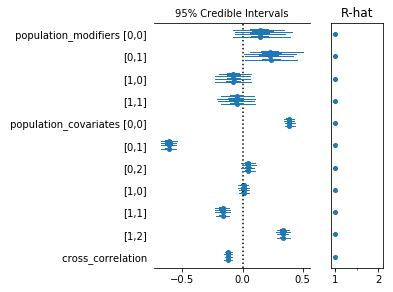

In [14]:
PM.forestplot(  trace \
              , varnames = ['population_modifiers','population_covariates','cross_correlation'] \
             )
PLT.show()

`R-hat`s are good, effects are visible.

In [15]:
PM.plot_posterior(trace, varnames = ['population_intercept','population_modifiers','population_covariates'])
PLT.show()

### Verdict

This relatively complex model ran (and converged) successfully in bearable time. 

Even more, the results are convenient in a sense that model input parameters could be recovered.

The traceplot reminded me that I forgot to add group effect on the covariate slopes - well, this happens. I'll have to go back to the simulation. I'm getting used to that.


The combination of model hierarchy and multivariate covariance is very powerful. However, there is [some indication](https://discourse.pymc.io/t/correlated-slopes-in-multivariate-model/1485/3) that the covariance structure for predicturs is not too meaningful in linear models. This changes if hierarchy is modeled ([see here](http://discourse.mc-stan.org/t/is-covariance-structure-necessary-in-multi-level-models/4314/7); covariates can be correlated across subjects) or, as I would think, if components have a non-linear relationship to the observable. 

## Prospect

More advanced diagnostics can be found in the recent ["Advance Bayesian Modelling with PyMC3"](https://discourse.pymc.io/t/advance-bayesian-modelling-with-pymc3/1439) presentation and notebooks by Junpeng Lao:
https://github.com/junpenglao/advance-bayesian-modelling-with-PyMC3, Sessions 5 and 6.

I strongly advise to follow that guide.

My TODOs:
- wrap this into a dynamic, object oriented model toolbox (facilitate model comparison)* 
- apply to real data
- model comparison
- posterior predictive checks; playing with the model parameters (sensitivity of observables)



*because I think notebooks are good for knowledge transfer, not for real work.

I hope you enjoyed reading this wrap-up!

A lot more work remains, and a lot more to learn, though this is a promising proof of concept for me personally.

Any feedback is welcome. As usual, I hid a subtle, yet devastating, conceptual bug somewhere in the code. Please let me know if you found it ;)